# Time-frequency analysis
This notebook re-analyzes and extracts power from the 
resting state???

In [39]:
# setup
import mne
import numpy as np
import pandas as pd
import os.path as op

# open preprocessed data
n_sub = '03'
task = 'induction1'
con_dict = {}
data_dir = '/Users/yeganeh/Codes/otka-preprocessing/data/Main-study/derivatives/mne-bids-pipeline'
epoch_name = f'sub-{n_sub}_ses-01_task-{task}_proc-clean_epo.fif'
raw_name = f'sub-{n_sub}_ses-01_task-{task}_proc-filt_raw.fif'

dir = op.join(data_dir, f'sub-{n_sub}/ses-01/eeg/{raw_name}')

# open clean epochs
# epoch = mne.read_epochs(dir)
raw = mne.io.read_raw(dir)



Opening raw data file /Users/yeganeh/Codes/otka-preprocessing/data/Main-study/derivatives/mne-bids-pipeline/sub-03/ses-01/eeg/sub-03_ses-01_task-induction1_proc-filt_raw.fif...
Isotrak not found
    Range : 0 ... 363259 =      0.000 ...   363.259 secs
Ready.


In [34]:
from mne.time_frequency import psd_welch
psd = psd_welch(raw, n_fft=1051, n_per_seg=1051, fmax=40)

Effective window size : 1.051 (s)


Effective window size : 2.048 (s)


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_40929/314449690.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=40, n_fft=None, n_overlap=0.5, spatial_colors=True)


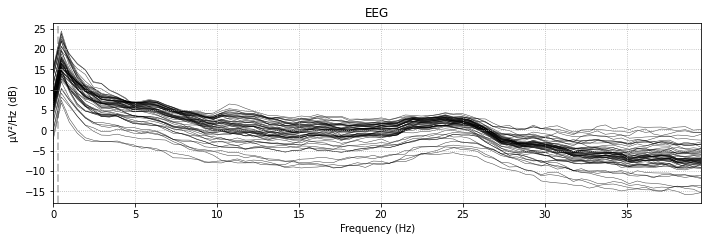

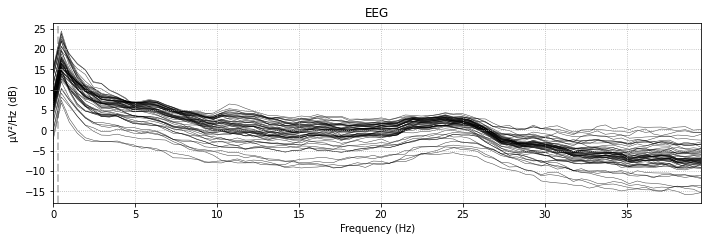

In [52]:
raw.plot_psd(fmax=40, n_fft=None, n_overlap=0.5, spatial_colors=True)